In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

from collections import defaultdict, Counter

In [2]:
"""
Functions
"""

def hint_length(s, ignore=None):
    """ determines length of hint, either with all characters or minus special characters"""
    if ignore == None:
        return len(s)
    try:
        ignore[0]
        l = len(s)
        for char in ignore:
            l = l - s.count(char)
        return l
    except IndexError:
        return len(s)-s.count(ignore)     

def num_one_word_hints(hlist):
    """ Returns number of one word hints from the list of hints for a puzzle"""
    num = 0
    for hint in hlist:
        if hint.count(' ') == 0:
            num += 1
    return num

def make_xword_feats(df):
    """Operates on crossword puzzle hints csv file from HTML scraper"""
    # convert year/month/day columns to single pd.datetime64 column
    df['date'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.Day))
    
    # Block density = fraction of board used for answers
    df['BlockDensity'] = (df['NumBlocks'] / (df['NumRows'] * df['NumCols']))*100
    
    # length of hint minus special characters
    df['HintLength']   = df['Hint'].apply(hint_length, args=([['-', "\""]]))
    
    # answer length, no special characters
    df['AnswerLength'] = df['Answer'].str.len()
    
    return df

In [3]:
"""
Load crossword puzzle hints from scraped HTML
""" 

xword1 = pd.read_csv("nick-xword-big.csv", converters={'Answer' : str, 'Hint' : str}, encoding='latin-1')
xword1 = make_xword_feats(xword1)

In [4]:
"""
Initial HTML scrape messed up 243 puzzles
"""

df_validate = xword1.groupby(['date','NumWords'])['Answer'].count().reset_index().copy()
t = df_validate[df_validate.Answer != df_validate.NumWords]
t

,date,NumWords,Answer
416,1995-02-22,72,16
445,1995-03-25,72,1
458,1995-04-08,72,5
477,1995-04-29,72,7
484,1995-05-06,66,7
...,...,...,...
9436,2020-02-14,72,68
9557,2020-06-14,140,43
9574,2020-07-01,75,57
9612,2020-08-08,70,25


In [5]:
"""
Remove bad puzzles
"""

for i, d in enumerate(t.date.values):
    # jupyter specific
    clear_output(wait=True)
    display(f"{i+1} of {len(t.date.values)}")
    
    xword1 = xword1.drop(xword1.loc[xword1.date == d].index)

'243 of 243'

In [6]:
"""
Reparse bad puzzles correctly
"""

xword2 = pd.read_csv("jv-xword-new.csv", converters={'Answer' : str, 'Hint' : str}, encoding='latin-1')
xword2 = make_xword_feats(xword2)

In [7]:
"""
Merge and check
"""

xword = pd.concat([xword1, xword2])

df_validate = xword.groupby(['date','NumWords'])['Answer'].count().reset_index().copy()
df_validate[df_validate.Answer != df_validate.NumWords]

# https://www.xwordinfo.com/Crossword?date=1/15/2004
# puzzle has double hints

,date,NumWords,Answer
3636,2004-01-15,78,80


In [8]:
"""
Number of unique answers per puzzle

Method 1 (ND)
"""

xword_uniques = xword.groupby(['date'])['Answer'].apply(list).reset_index().copy()

ans_dict = defaultdict(list)

# build a dictionary with answers for keys and puzzles for values
for index, row in xword_uniques.iterrows():
    for ans in row['Answer']:
        ans_dict[ans].append(index)

# find all keys mapped to only one puzzle
unique_ans = [hint for hint, pz in ans_dict.items() if len(pz) == 1]

# take the intersection of a puzzle's answers with the unique answer set (applied below)
def get_unique_clues(row):
    return list(set(row).intersection(set(unique_ans)))

# Adds a column that says how many other puzzles have this answer
xword['OtherPuzAns'] = xword['Answer'].apply(lambda x: len(ans_dict[x]))

In [9]:
"""
Group hints per puzzle together
"""

# 9757 total puzzles in dataset
df = xword.groupby(['date', 'Weekday'])[['Hint', 'HintLength', 'Answer', 'AnswerLength', 'OtherPuzAns', 'BlockDensity']].agg(list).reset_index()

In [10]:
"""
Make Features
"""

features = df.copy()

features['AvgHintLength'] = df['HintLength'].apply(np.mean)

features['AvgAnswerLength'] = df['AnswerLength'].apply(np.mean)

features['NumHints'] = df['Hint'].apply(len)

features['NumOneWordHints'] = df['Hint'].apply(num_one_word_hints)

features['OtherPuzAns'] = df['OtherPuzAns'].apply(sum)

features['BlockDensity'] = df['BlockDensity'].apply(np.mean)

# Monday is 0
# Sunday is 6
features['WeekdayNum'] = df['date'].dt.dayofweek

In [11]:
%%time

"""
Number of unique answers per puzzle

Method 2 (JV)
"""
def num_repeated_answers(df):
    n = [] # number of repeated answers
    NN = [] # total number of unique answers
    n.append(0)
    all_previous = set(df.iloc[0].Answer)
    NN.append(len(all_previous))
    for i, j in enumerate(range(1, len(df))):
        # jupyter specific
        clear_output(wait=True)
        display(f"{i+1} of {len(df)+1}")
        
        current_day = pd.to_datetime(df.iloc[j].date)
        # print(current_day)
        current_answers = set(df.iloc[j].Answer)
        
        # number of answers in current puzzle that were present in a previous puzzle
        n.append(len(current_answers.intersection(all_previous)))
        
        # total number of possible puzzle answers so far (not including this puzzle)
        NN.append(len(all_previous))
        
        all_previous = current_answers.union(all_previous)
        
    return n, NN

features['NumRepeatedAnswers'], features['CumTotalAnswers'] = num_repeated_answers(features)

features['NumRepeatedAnswers_Norm'] = features['NumRepeatedAnswers'] / (features['CumTotalAnswers']*features['NumHints'])

'9756 of 9758'

Wall time: 1min 44s


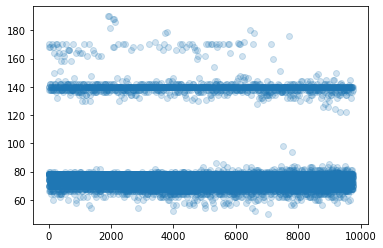

In [12]:
# Sunday puzzles are bigger

plt.plot(features['NumHints'], 'o', alpha=0.2)

In [13]:
"""
Export to csv
"""

features.to_csv('jv-features.csv', index=False,
                  columns = ['date', 'Weekday', 'WeekdayNum', 'AvgHintLength', 'AvgAnswerLength', 
                            'NumHints', 'NumOneWordHints', 'BlockDensity', 'OtherPuzAns', 'NumRepeatedAnswers', 'NumRepeatedAnswers_Norm', 'CumTotalAnswers'])

In [14]:
"""
Check
"""

df2 = pd.read_csv('jv-features.csv')
df2['date'] = pd.to_datetime(df2['date'])

df2

,date,Weekday,WeekdayNum,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,BlockDensity,OtherPuzAns,NumRepeatedAnswers,NumRepeatedAnswers_Norm,CumTotalAnswers
0,1994-01-01,Saturday,5,14.969697,5.666667,66,15,16.888889,3093,0,0.000000,66
1,1994-01-02,Sunday,6,15.547059,4.976471,170,33,20.037807,11874,0,0.000000,66
2,1994-01-03,Monday,0,13.368421,4.815789,76,16,18.666667,6770,1,0.000056,236
3,1994-01-04,Tuesday,1,14.602564,4.846154,78,13,16.000000,6572,5,0.000206,311
4,1994-01-05,Wednesday,2,13.312500,4.675000,80,24,16.888889,6352,2,0.000065,384
...,...,...,...,...,...,...,...,...,...,...,...,...
9752,2020-12-27,Sunday,6,22.289855,5.289855,138,8,17.233560,10639,130,0.000008,115604
9753,2020-12-28,Monday,0,21.333333,4.846154,78,4,16.000000,6200,77,0.000009,115612
9754,2020-12-29,Tuesday,1,21.653846,4.846154,78,8,16.000000,6977,70,0.000008,115613
9755,2020-12-30,Wednesday,2,20.459459,5.162162,74,12,15.111111,6170,71,0.000008,115621


In [15]:

df2.date

0      1994-01-01
1      1994-01-02
2      1994-01-03
3      1994-01-04
4      1994-01-05
          ...    
9752   2020-12-27
9753   2020-12-28
9754   2020-12-29
9755   2020-12-30
9756   2020-12-31
Name: date, Length: 9757, dtype: datetime64[ns]